In [7]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ====================================
# Dataset loader
# ====================================
class Signal1DDataset(Dataset):
    def __init__(self, root_dir, params_csv, allowed_experiments=None,
                 normalize_signals=True, normalize_conditions=True):
        self.root_dir = root_dir
        self.params_df = pd.read_csv(params_csv)

        if allowed_experiments is not None:
            self.params_df = self.params_df[self.params_df["experiment"].isin(allowed_experiments)]

        self.samples = []
        for _, row in self.params_df.iterrows():
            folder_id = str(int(row["experiment"]))
            folder_path = os.path.join(root_dir, folder_id)
            if not os.path.isdir(folder_path):
                continue
            for fname in os.listdir(folder_path):
                if fname.lower().endswith(".csv"):
                    fpath = os.path.join(folder_path, fname)
                    conditions = row.drop("experiment").values
                    self.samples.append((fpath, conditions))

        print(f"Načteno {len(self.samples)} souborů (experiments={allowed_experiments})")

        self.normalize_signals = normalize_signals
        self.normalize_conditions = normalize_conditions
        if normalize_conditions and len(self.samples) > 0:
            all_conditions = np.stack([s[1] for s in self.samples])
            self.cond_mean = all_conditions.mean(axis=0)
            self.cond_std = all_conditions.std(axis=0)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        signal_path, cond = self.samples[idx]
        df = pd.read_csv(signal_path)

        if "intensity" in df.columns:
            signal = df["intensity"].values.astype(np.float32)
        else:
            signal = df.iloc[:, -1].values.astype(np.float32)

        if self.normalize_signals:
            signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)
            signal = signal * 2.0 - 1.0

        cond = cond.astype(np.float32)
        if self.normalize_conditions:
            cond = (cond - self.cond_mean) / (self.cond_std + 1e-8)

        return torch.from_numpy(signal), torch.from_numpy(cond)


# ====================================
# Modely GANu
# ====================================
class Generator1D(nn.Module):
    def __init__(self, noise_dim=64, cond_dim=5, signal_len=450):
        super().__init__()
        input_dim = noise_dim + cond_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, signal_len),
            nn.Tanh()
        )
    def forward(self, noise, cond):
        x = torch.cat([noise, cond], dim=1)
        return self.net(x)


class Discriminator1D(nn.Module):
    def __init__(self, cond_dim=5, signal_len=450):
        super().__init__()
        input_dim = signal_len + cond_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, signal, cond):
        x = torch.cat([signal, cond], dim=1)
        return self.net(x)


# ====================================
# Trénink GANu
# ====================================
def train_gan(G, D, train_loader, noise_dim, num_epochs=50, lr=0.0002, device="cpu"):
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

    history = {"loss_D": [], "loss_G": []}

    for epoch in range(num_epochs):
        for signals, conds in train_loader:
            signals = signals.to(device).float()
            conds = conds.to(device).float()
            b_size = signals.size(0)

            # --- Discriminator ---
            D.zero_grad()
            labels_real = torch.full((b_size, 1), 1.0, device=device)
            output_real = D(signals, conds)
            loss_D_real = criterion(output_real, labels_real)
            loss_D_real.backward()

            noise = torch.randn(b_size, noise_dim, device=device)
            fake_signals = G(noise, conds)
            labels_fake = torch.full((b_size, 1), 0.0, device=device)
            output_fake = D(fake_signals.detach(), conds)
            loss_D_fake = criterion(output_fake, labels_fake)
            loss_D_fake.backward()

            loss_D = loss_D_real + loss_D_fake
            optimizer_D.step()

            # --- Generator ---
            G.zero_grad()
            labels_fake.fill_(1.0)  # chceme, aby fake vypadal jako real
            output = D(fake_signals, conds)
            loss_G = criterion(output, labels_fake)
            loss_G.backward()
            optimizer_G.step()

        history["loss_D"].append(loss_D.item())
        history["loss_G"].append(loss_G.item())
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")

    return history


# ====================================
# Validace GANu
# ====================================
def validate_gan(G, val_dataset, noise_dim=64, num_samples=5, device="cpu"):
    G.eval()
    indices = np.random.choice(len(val_dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 8), sharex=True)
    for i, idx in enumerate(indices):
        real_signal, cond = val_dataset[idx]
        cond = cond.unsqueeze(0).to(device).float()
        noise = torch.randn(1, noise_dim, device=device)
        with torch.no_grad():
            fake_signal = G(noise, cond).cpu().numpy().flatten()

        axes[i].plot(real_signal.numpy(), label="Real", color="black")
        axes[i].plot(fake_signal, label="Generated", color="red", alpha=0.7)
        axes[i].legend()
    plt.suptitle("Validace: reálné vs. generované signály")
    plt.show()


# ====================================
# Hlavní běh
# ====================================
if __name__ == "__main__":
    root_dir = "1D_spec"
    params_csv = "1D_spec/params.csv"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # rozdělení experiments na train/val
    params_df = pd.read_csv(params_csv)
    all_experiments = params_df["experiment"].unique()
    np.random.shuffle(all_experiments)
    split_ratio = 0.8
    split_idx = int(len(all_experiments) * split_ratio)
    train_exps = all_experiments[:split_idx]
    val_exps = all_experiments[split_idx:]

    train_dataset = Signal1DDataset(root_dir, params_csv, allowed_experiments=train_exps)
    val_dataset   = Signal1DDataset(root_dir, params_csv, allowed_experiments=val_exps)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    noise_dim = 64
    cond_dim = train_dataset[0][1].shape[0]
    signal_len = train_dataset[0][0].shape[0]

    G = Generator1D(noise_dim=noise_dim, cond_dim=cond_dim, signal_len=signal_len).to(device)
    D = Discriminator1D(cond_dim=cond_dim, signal_len=signal_len).to(device)

    # trénink
    history = train_gan(G, D, train_loader, noise_dim, num_epochs=50, device=device)

    # graf lossů
    plt.figure(figsize=(8,5))
    plt.plot(history["loss_D"], label="Discriminator")
    plt.plot(history["loss_G"], label="Generator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Průběh tréninku")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # validace
    validate_gan(G, val_dataset, noise_dim=noise_dim, num_samples=5, device=device)


Načteno 955 souborů (experiments=[17  3 15 14 22 13  2 21 10 19 16  7  8 20  6  4  5])
Načteno 324 souborů (experiments=[ 9 18 12 11  1])
Epoch [1/50] Loss_D: 1.3413 Loss_G: 0.6230
Epoch [2/50] Loss_D: 1.3072 Loss_G: 0.7766
Epoch [3/50] Loss_D: 1.3905 Loss_G: 0.8302
Epoch [4/50] Loss_D: 1.3540 Loss_G: 0.8576
Epoch [5/50] Loss_D: 1.4049 Loss_G: 0.7780


KeyboardInterrupt: 

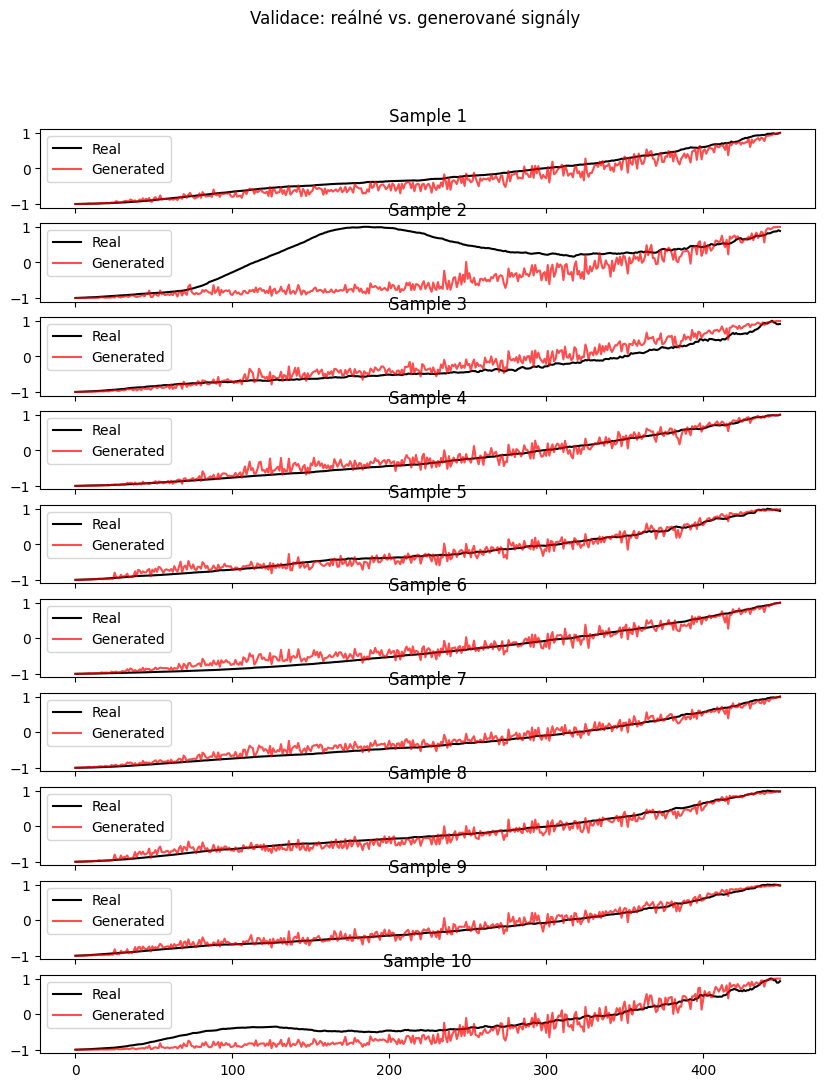

📊 Výsledky validace:
 sample_id      MSE     Corr        R2   CosSim  DTW_dist
       161 0.023372 0.977705  0.921650 0.967690       NaN
       175 0.752143 0.425325 -1.064555 0.131526       NaN
        91 0.037472 0.973869  0.843247 0.947287       NaN
       123 0.016765 0.977959  0.950355 0.978593       NaN
       249 0.012861 0.978544  0.956880 0.981191       NaN
        36 0.022148 0.975429  0.934463 0.978719       NaN
       159 0.014695 0.982754  0.951201 0.983015       NaN
       208 0.012336 0.980335  0.958559 0.981320       NaN
       247 0.010101 0.985610  0.965783 0.985386       NaN
       104 0.069213 0.945471  0.676216 0.955305       NaN

📈 Shrnutí (průměr přes všechny vzorky):
MSE       : 0.097111
Corr      : 0.920300
R2        : 0.709380
CosSim    : 0.889003
DTW_dist  : NaN


In [14]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine, euclidean
from fastdtw import fastdtw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

def validate_gan(G, val_dataset, noise_dim=64, num_samples=10, device="cpu"):
    """
    Validace GANu:
    - vykreslí real vs. generated signály
    - spočítá metriky: MSE, Corr, R2, Cosine similarity, DTW distance
    - vytiskne tabulku výsledků a průměrné hodnoty
    """
    G.eval()
    indices = np.random.choice(len(val_dataset), num_samples, replace=False)

    results = []
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 12), sharex=True)

    for i, idx in enumerate(indices):
        real_signal, cond = val_dataset[idx]
        cond = cond.unsqueeze(0).to(device).float()
        noise = torch.randn(1, noise_dim, device=device)

        with torch.no_grad():
            fake_signal = G(noise, cond).cpu().numpy().ravel()

        real_np = np.array(real_signal.numpy()).ravel()  # vždy 1D

        # --- metriky ---
        mse = mean_squared_error(real_np, fake_signal)

        try:
            corr, _ = pearsonr(real_np, fake_signal)
        except Exception:
            corr = np.nan

        try:
            r2 = r2_score(real_np, fake_signal)
        except Exception:
            r2 = np.nan

        try:
            cos_sim = 1 - cosine(real_np, fake_signal)
        except Exception:
            cos_sim = np.nan

        try:
            dtw_dist, _ = fastdtw(real_np, fake_signal, dist=euclidean)
        except Exception:
            dtw_dist = np.nan

        results.append({
            "sample_id": idx,
            "MSE": mse,
            "Corr": corr,
            "R2": r2,
            "CosSim": cos_sim,
            "DTW_dist": dtw_dist
        })

        # --- graf ---
        axes[i].plot(real_np, label="Real", color="black")
        axes[i].plot(fake_signal, label="Generated", color="red", alpha=0.7)
        axes[i].legend()
        axes[i].set_title(f"Sample {i+1}")

    plt.suptitle("Validace: reálné vs. generované signály")
    plt.show()

    # --- tabulka výsledků ---
    df = pd.DataFrame(results)
    print("Výsledky validace:")
    print(df.to_string(index=False))

    # --- agregované statistiky ---
    print("\n Shrnutí (průměr přes všechny vzorky):")
    for col in ["MSE", "Corr", "R2", "CosSim", "DTW_dist"]:
        vals = df[col].dropna()
        if len(vals) > 0:
            print(f"{col:10s}: {vals.mean():.6f}")
        else:
            print(f"{col:10s}: NaN")


validate_gan(G, val_dataset, noise_dim=noise_dim, num_samples=10, device=device)




In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

def analyze_experiments(params_csv, experiments, root_dir, dataset, G, noise_dim,
                        device="cpu", save_dir="results_biggerL1", epoch=None, n_fake=5):
    """
    Najde a vykreslí všechny signály pro vybrané experimenty.
    Uloží výsledky do složky save_dir.

    Args:
        params_csv (str): cesta k params.csv
        experiments (list): seznam ID experimentů k analýze
        root_dir (str): složka s daty (např. "1D_spec")
        dataset (Signal1DDataset): dataset pro načtení signálů
        G (nn.Module): generátor
        noise_dim (int): dimenze latentního vektoru
        device (str): "cpu" nebo "cuda"
        save_dir (str): složka pro uložení grafů
        epoch (int): číslo epochy (přidáno do názvu souboru)
        n_fake (int): počet generovaných vzorků pro vizualizaci
    """
    os.makedirs(save_dir, exist_ok=True)
    params_df = pd.read_csv(params_csv)
    cond_columns = [c for c in params_df.columns if c != "experiment"]

    for exp_id in experiments:
        print(f"\n=== Experiment {exp_id} ===")
        # všechny signály pro experiment
        real_signals = []
        cond_tensor = None

        for i in range(len(dataset)):
            signal, cond = dataset[i]
            cond_dict = dict(zip(cond_columns, cond.numpy()))

            # podmínka na experiment ID
            if int(params_df.iloc[i]["experiment"]) == exp_id:
                real_signals.append(signal.numpy())
                cond_tensor = cond.unsqueeze(0).to(device).float()

        if cond_tensor is None:
            print(f"⚠️ Experiment {exp_id} nebyl nalezen v datasetu.")
            continue

        # vykreslení
        fig, ax = plt.subplots(figsize=(10, 5))

        for sig in real_signals:
            ax.plot(sig, color="black", alpha=0.5, label="Real" if sig is real_signals[0] else "")

        for j in range(n_fake):
            noise = torch.randn(1, noise_dim, device=device)
            with torch.no_grad():
                fake_sig = G(noise, cond_tensor).cpu().numpy().flatten()
            ax.plot(fake_sig, color="red", alpha=0.7, label="Generated" if j==0 else "")

        title = f"Experiment {exp_id} (Epoch {epoch})"
        ax.set_title(title)
        ax.legend()

        fname = f"experiment{exp_id}_epoch{epoch}.png" if epoch is not None else f"experiment{exp_id}.png"
        plt.savefig(os.path.join(save_dir, fname), dpi=200)
        plt.close()

        print(f" Uloženo: {os.path.join(save_dir, fname)}")


In [6]:
import os
import json
import torch
import pandas as pd

# === 1. Složka nejlepšího běhu ===
best_run_dir = "results02/lambda20_epochs70_20250927_011649"  # ← dosaď správnou složku

# === 2. Načti config ===
with open(os.path.join(best_run_dir, "config.json")) as f:
    config = json.load(f)

noise_dim = config["noise_dim"]
cond_dim = config["cond_dim"]
signal_len = config["signal_len"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Použité zařízení:", device)

# === 3. Postav modely ===
G = Generator1D(noise_dim=noise_dim, cond_dim=cond_dim, signal_len=signal_len).to(device)
D = Discriminator1D(cond_dim=cond_dim, signal_len=signal_len).to(device)

# === 4. Nahraj váhy ===
G.load_state_dict(torch.load(os.path.join(best_run_dir, "generator.pth"), map_location=device))
D.load_state_dict(torch.load(os.path.join(best_run_dir, "discriminator.pth"), map_location=device))
G.eval()
D.eval()
print(" Model nahrán.")

# === 5. Načti validační metriky ===
df_metrics = pd.read_csv(os.path.join(best_run_dir, "validation_metrics.csv"))
print("Validation metrics:", df_metrics.describe())

# === 6. Analyzuj problematické podmínky ===
experiments = [15, 17, 18]  # tyto jsme dříve identifikovali jako problematické


analyze_experiments(
    params_csv="1D_spec/params.csv",
    experiments=experiments,
    root_dir="1D_spec",
    dataset=val_dataset,
    G=G,
    noise_dim=noise_dim,
    device=device,
    save_dir="results_biggerL1",
    epoch=70,
    n_fake=5
)


Použité zařízení: cpu


NameError: name 'Generator1D' is not defined

In [5]:
df = pd.read_csv(os.path.join(best_run_dir, "validation_metrics.csv"))
print(df.describe())

# problémové vzorky
problematic = df[df["Corr"] < 0.6]
print(problematic.head())


FileNotFoundError: [Errno 2] No such file or directory: 'esults02/lambda20_epochs70_20250927_011649/validation_metrics.csv'